In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from skimage import exposure
from skimage.transform import rotate
from skimage import draw
%matplotlib inline


import cv2
import cv2 as cv

In [155]:
pre_train = pd.read_csv('sign_mnist_train.csv')
pre_test = pd.read_csv('sign_mnist_test.csv')



**TAKE A LOOK**

In [156]:
pre_train.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [157]:
#CHECK FOR NULL
print(pre_train.isnull().sum())
print(pre_test.isnull().sum())



label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [158]:
train_set, val_set = train_test_split(pre_train, test_size=0.3,stratify=pre_train["label"], random_state=42)

In [159]:
print(type(train_set))

<class 'pandas.core.frame.DataFrame'>


In [160]:
def process_raw_file_into_dataset_and_label(df_link, hist=False):
    # check filename or DataFrame
    if isinstance(df_link, str):
        df = pd.read_csv(df_link)
    elif isinstance(df_link, pd.DataFrame):
        df = df_link
    else:
        raise ValueError("Input must be a file path or a pandas DataFrame")

    # separate label
    labels = df['label'].values

    #delete label column
    pixels = df.drop(columns=['label']).values
    pixels = pixels.astype(np.float64)

    return pixels, labels


In [161]:
# read data from csv file
X_train, y_train = process_raw_file_into_dataset_and_label(train_set)
X_val, y_val = process_raw_file_into_dataset_and_label(val_set)
X_test, y_test = process_raw_file_into_dataset_and_label(pre_test)

# normalize data from 0 to 1 range
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255



Prepare augmented_data for DCT that we have already made in HOG

In [162]:
augmented_data = np.array(pd.read_csv("augmented_data.csv"))
augmented_labels = np.array(pd.read_csv("augmented_label.csv"))

In [163]:
augmented_labels1 = np.squeeze(augmented_labels)

Concatenate augmented data

In [164]:
X_train_DCT_augmented_data = np.vstack((augmented_data, X_train))
y_train_DCT_augmented_data = np.concatenate((augmented_labels1, y_train))

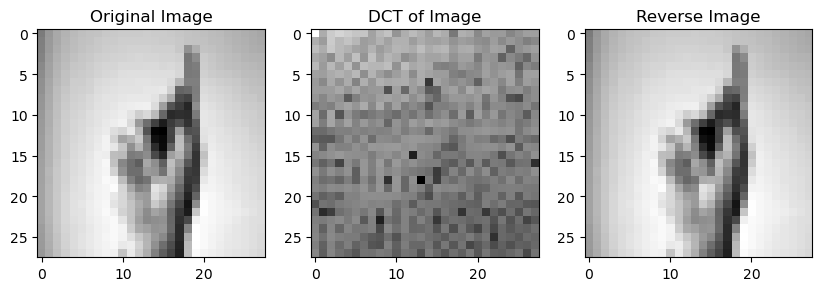

In [165]:
def dct2(img):
    return cv2.dct(img)

def idct2(img):
    return cv2.idct(img)

image = X_train[1].reshape(28,28)

# Compute the 2D DCT of the image
dct_result = cv2.dct(image)

dct_reverse = idct2(dct_result)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Original image
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
# DCT result
axs[1].imshow(np.log(abs(dct_result)), cmap='gray')  # Use log scale for visibility
axs[1].set_title('DCT of Image')
#Reverse image
axs[2].imshow(dct_reverse, cmap='gray')
axs[2].set_title('Reverse Image')

plt.show()


Basis function that DCT decompose the image

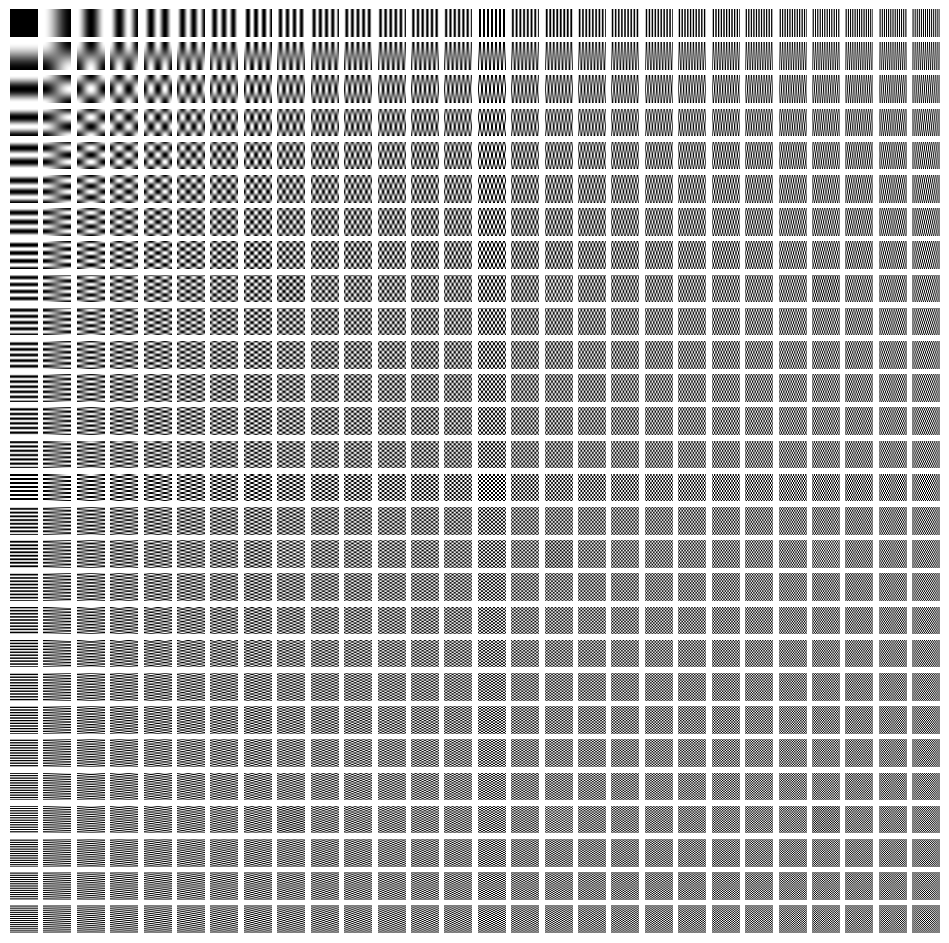

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct

# Function to compute 2D DCT basis
def dct2_basis(x, y, u, v, N):
    alpha_u = np.sqrt(1.0/N) if u == 0 else np.sqrt(2.0/N)
    alpha_v = np.sqrt(1.0/N) if v == 0 else np.sqrt(2.0/N)
    return alpha_u * alpha_v * np.cos((2*x + 1)*u*np.pi/(2.0*N)) * np.cos((2*y + 1)*v*np.pi/(2.0*N))

# Generate DCT basis for 28x28 image
N = 28
basis = np.zeros((N, N, N, N))
for u in range(N):
    for v in range(N):
        for x in range(N):
            for y in range(N):
                basis[x, y, u, v] = dct2_basis(x, y, u, v, N)

# Plot the DCT basis
fig, axs = plt.subplots(N, N, figsize=(12, 12))
for u in range(N):
    for v in range(N):
        axs[u, v].imshow(basis[:, :, u, v], cmap='gray')
        axs[u, v].axis('off')

plt.show()


NOT every basis is neccessary, the first in zig zag order that is important

In [167]:
def zigzag_extract(input, n=None):
    #initializing the variables
    #----------------------------------
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    vmax = input.shape[0]
    hmax = input.shape[1]
    
    #print(vmax ,hmax )

    i = 0

    output = np.zeros(( vmax * hmax))
    #----------------------------------

    while ((v < vmax) and (h < hmax)):
    	
        if ((h + v) % 2) == 0:                 # going up
            
            if (v == vmin):
            	#print(1)
                output[i] = input[v, h]        # if we got to the first line

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        

                i = i + 1

            elif ((h == hmax -1 ) and (v < vmax)):   # if we are at the last column
            	#print(2)
            	output[i] = input[v, h] 
            	v = v + 1
            	i = i + 1

            elif ((v > vmin) and (h < hmax -1 )):    # all other cases
            	#print(3)
            	output[i] = input[v, h] 
            	v = v - 1
            	h = h + 1
            	i = i + 1

        
        else:                                    # going down

        	if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
        		#print(4)
        		output[i] = input[v, h] 
        		h = h + 1
        		i = i + 1
        
        	elif (h == hmin):                  # if we got to the first column
        		#print(5)
        		output[i] = input[v, h] 

        		if (v == vmax -1):
        			h = h + 1
        		else:
        			v = v + 1

        		i = i + 1

        	elif ((v < vmax -1) and (h > hmin)):     # all other cases
        		#print(6)
        		output[i] = input[v, h] 
        		v = v + 1
        		h = h - 1
        		i = i + 1




        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
        	#print(7)        	
        	output[i] = input[v, h] 
        	break
    if n is not None:
        output = output[:n]
    return output

DCT Upper left corner or zigzag

In [168]:
#this function will return Upper left corner mxm matrix flatten features, or zigzag n - order features
def raw_to_dct_order_feature(set, n = None, m = None, zigzag = True):
    # Initialize an empty list to store the DCT features
    dct_features = []

    k = len(set)
    # Loop over all rows in the set
    for i in range(k):

        dct_image = cv2.dct(set[i].reshape(28,28))

        if zigzag == True:
            # Zigzag_extract function
            dct_feature = zigzag_extract(dct_image)

            # Keep first n features
            dct_feature = dct_feature[:n]
            dct_feature = dct_feature*np.hamming(n)
        else:
            # Take the upper left corner of size m x m and flatten it
            dct_feature = dct_image[:m, :m]
            dct_feature = dct_feature.flatten()
        # Append the DCT feature to the list of features
        dct_features.append(dct_feature)

    # Convert the list of features to a numpy array
    dct_features = np.array(dct_features)

    return dct_features


0. Model : raw with PCA

In [169]:
def dct_flatten_feature(img):
    feature = cv2.dct(img.reshape(28,28))
    feature = feature.flatten()
    return feature

In [170]:
#already done and save
X_train_DCT_raw = Parallel(n_jobs=-1)(delayed(dct_flatten_feature)(img) for img in X_train)
X_test_DCT_raw = Parallel(n_jobs=-1)(delayed(dct_flatten_feature)(img) for img in X_test)

In [171]:
pca = PCA(n_components = 80)
X_train_DCT_raw_pca = pca.fit_transform(X_train_DCT_raw)
X_test_DCT_raw_pca = pca.transform(X_test_DCT_raw)

#time measure
start = time.time()

#main
model_svm0 = SVC(kernel = 'rbf')
model_svm0.fit(X_train_DCT_raw_pca, y_train)

end = time.time()
print("Fit time:", end - start)

predictions = model_svm0.predict(X_train_DCT_raw_pca)
print(classification_report(predictions, y_train))
predictions = model_svm0.predict(X_test_DCT_raw_pca)
print(classification_report(predictions, y_test))

Fit time: 13.901038646697998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       789
           1       1.00      1.00      1.00       707
           2       1.00      1.00      1.00       801
           3       1.00      1.00      1.00       837
           4       1.00      1.00      1.00       669
           5       1.00      1.00      1.00       843
           6       1.00      1.00      1.00       761
           7       1.00      1.00      1.00       709
           8       1.00      1.00      1.00       812
          10       1.00      1.00      1.00       782
          11       1.00      1.00      1.00       869
          12       1.00      1.00      1.00       738
          13       1.00      1.00      1.00       808
          14       1.00      1.00      1.00       837
          15       1.00      1.00      1.00       762
          16       1.00      1.00      1.00       895
          17       1.00      1.00      1.00       90

In [172]:
for i in range(30, 80, 10):
    print(str(i)+' components')
    pca = PCA(n_components = i)
    X_train_DCT_raw_pca = pca.fit_transform(X_train_DCT_raw)
    X_test_DCT_raw_pca = pca.transform(X_test_DCT_raw)

    #time measure
    start = time.time()

    #main
    model_svm0 = SVC(kernel = 'rbf')
    model_svm0.fit(X_train_DCT_raw_pca, y_train)

    end = time.time()
    print("Fit time:", end - start)

    predictions = model_svm0.predict(X_train_DCT_raw_pca)
    print(classification_report(predictions, y_train))
    predictions = model_svm0.predict(X_test_DCT_raw_pca)
    print(classification_report(predictions, y_test))

30 components
Fit time: 10.482037782669067
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       797
           1       1.00      1.00      1.00       707
           2       1.00      1.00      1.00       801
           3       1.00      0.99      0.99       845
           4       1.00      1.00      1.00       671
           5       1.00      1.00      1.00       842
           6       0.98      1.00      0.99       753
           7       1.00      1.00      1.00       708
           8       0.99      1.00      0.99       805
          10       1.00      0.99      0.99       786
          11       1.00      1.00      1.00       870
          12       0.98      1.00      0.99       721
          13       1.00      0.98      0.99       824
          14       1.00      1.00      1.00       837
          15       1.00      1.00      1.00       762
          16       1.00      1.00      1.00       895
          17       0.95      0.97     

1.Model: DCT feature with top left corner matrix 10x10 of coefficient, no zig zag

In [173]:
X_train_DCT_nozigzag = raw_to_dct_order_feature(X_train, m = 10,zigzag = False)
y_train_DCT_nozigzag = y_train

X_test_DCT_nozigzag = raw_to_dct_order_feature(X_test, m = 10,zigzag = False)

In [174]:
#time measure
start = time.time()

#main
model_knn1 = KNeighborsClassifier(n_neighbors=3)
model_knn1.fit(X_train_DCT_nozigzag, y_train_DCT_nozigzag)

end = time.time()
print("Fit time:", end - start)



Fit time: 0.009995698928833008


In [175]:
predictions = model_knn1.predict(X_train_DCT_nozigzag)
print(classification_report(predictions, y_train_DCT_nozigzag))
predictions = model_knn1.predict(X_test_DCT_nozigzag)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       787
           1       1.00      1.00      1.00       709
           2       1.00      1.00      1.00       802
           3       1.00      1.00      1.00       839
           4       1.00      1.00      1.00       671
           5       1.00      1.00      1.00       843
           6       1.00      1.00      1.00       763
           7       1.00      1.00      1.00       709
           8       1.00      1.00      1.00       814
          10       1.00      1.00      1.00       779
          11       1.00      1.00      1.00       868
          12       1.00      1.00      1.00       738
          13       1.00      1.00      1.00       806
          14       1.00      1.00      1.00       836
          15       1.00      1.00      1.00       762
          16       1.00      1.00      1.00       895
          17       1.00      0.99      1.00       911
          18       1.00    

In [176]:
#time measure
start = time.time()

#main
model_logistic1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000)
model_logistic1.fit(X_train_DCT_nozigzag, y_train_DCT_nozigzag)

end = time.time()
print("Fit time:", end - start)

Fit time: 25.024234294891357


In [177]:
predictions = model_logistic1.predict(X_train_DCT_nozigzag)
print(classification_report(predictions, y_train_DCT_nozigzag))
predictions = model_logistic1.predict(X_test_DCT_nozigzag)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       797
           1       1.00      1.00      1.00       709
           2       1.00      1.00      1.00       801
           3       0.97      0.97      0.97       842
           4       1.00      1.00      1.00       670
           5       0.97      1.00      0.98       824
           6       0.99      1.00      1.00       757
           7       1.00      1.00      1.00       710
           8       0.97      0.98      0.97       800
          10       0.97      0.97      0.97       776
          11       1.00      0.97      0.98       890
          12       1.00      1.00      1.00       740
          13       0.99      1.00      0.99       800
          14       1.00      1.00      1.00       837
          15       1.00      1.00      1.00       763
          16       1.00      0.99      1.00       897
          17       0.93      0.96      0.95       878
          18       0.98    

In [178]:
#time measure
start = time.time()

#main
model_svm1 = SVC(kernel = 'rbf')
model_svm1.fit(X_train_DCT_nozigzag, y_train_DCT_nozigzag)

end = time.time()
print("Fit time:", end - start)

Fit time: 29.692179441452026


In [179]:
predictions = model_svm1.predict(X_train_DCT_nozigzag)
print(classification_report(predictions, y_train_DCT_nozigzag))
predictions = model_svm1.predict(X_test_DCT_nozigzag)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       848
           1       0.98      0.95      0.96       724
           2       0.98      1.00      0.99       786
           3       0.87      0.80      0.83       915
           4       0.91      0.96      0.93       636
           5       0.90      0.94      0.92       808
           6       0.85      0.92      0.89       703
           7       0.86      0.97      0.91       632
           8       0.87      0.86      0.86       831
          10       0.77      0.69      0.73       876
          11       0.94      0.90      0.92       905
          12       0.72      0.91      0.80       584
          13       0.89      0.88      0.88       815
          14       0.95      0.98      0.97       812
          15       0.99      0.96      0.98       788
          16       0.98      0.98      0.98       899
          17       0.68      0.63      0.65       979
          18       0.83    

2. Model DCT feature with zig zag first 100 coefficient, no augmented_data

In [180]:
X_train_DCT_100first = raw_to_dct_order_feature(X_train_DCT_augmented_data, n = 100, zigzag = True)
y_train_DCT_100first = y_train_DCT_augmented_data

X_test_DCT_100first = raw_to_dct_order_feature(X_test, n = 100,zigzag = True)

In [181]:
start = time.time()

model_knn2 = KNeighborsClassifier(n_neighbors=3)
model_knn2.fit(X_train_DCT_100first, y_train_DCT_100first)

end = time.time()
print("Fit time:", end - start)

Fit time: 0.018014907836914062


In [182]:
predictions = model_knn2.predict(X_train_DCT_100first)
print(classification_report(predictions, y_train_DCT_100first))
predictions = model_knn2.predict(X_test_DCT_100first)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      1619
         1.0       0.99      0.95      0.97      1474
         2.0       0.99      1.00      0.99      1599
         3.0       0.97      0.97      0.97      1669
         4.0       0.97      0.98      0.98      1336
         5.0       0.99      0.99      0.99      1690
         6.0       0.99      0.98      0.99      1533
         7.0       0.99      0.98      0.98      1432
         8.0       0.97      0.97      0.97      1626
        10.0       0.98      0.96      0.97      1588
        11.0       0.99      0.99      0.99      1744
        12.0       0.96      0.98      0.97      1446
        13.0       0.96      0.96      0.96      1620
        14.0       0.99      0.99      0.99      1670
        15.0       0.99      1.00      0.99      1512
        16.0       0.99      1.00      0.99      1769
        17.0       0.95      0.95      0.95      1823
        18.0       0.96    

In [183]:
start = time.time()

model_logistic2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000)
model_logistic2.fit(X_train_DCT_100first, y_train_DCT_100first)

end = time.time()
print("Fit time:", end - start)

Fit time: 7.172996520996094


In [184]:
predictions = model_logistic2.predict(X_train_DCT_100first)
print(classification_report(predictions, y_train_DCT_100first))
predictions = model_logistic2.predict(X_test_DCT_100first)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75      1581
         1.0       0.75      0.81      0.78      1307
         2.0       0.87      0.89      0.88      1553
         3.0       0.64      0.68      0.66      1591
         4.0       0.75      0.80      0.77      1267
         5.0       0.69      0.71      0.70      1623
         6.0       0.74      0.78      0.76      1451
         7.0       0.70      0.73      0.72      1357
         8.0       0.71      0.66      0.68      1763
        10.0       0.72      0.65      0.68      1728
        11.0       0.76      0.67      0.71      1975
        12.0       0.64      0.70      0.67      1356
        13.0       0.65      0.69      0.67      1508
        14.0       0.78      0.82      0.80      1588
        15.0       0.81      0.75      0.78      1648
        16.0       0.80      0.78      0.79      1837
        17.0       0.55      0.54      0.54      1854
        18.0       0.60    

In [185]:
#time measure
start = time.time()

#main
model_svm2 = SVC(kernel = 'rbf')
model_svm2.fit(X_train_DCT_100first, y_train_DCT_100first)

end = time.time()
print("Fit time:", end - start)

Fit time: 78.56911325454712


In [186]:
predictions = model_svm2.predict(X_train_DCT_100first)
print(classification_report(predictions, y_train_DCT_100first))
predictions = model_svm2.predict(X_test_DCT_100first)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      1553
         1.0       0.97      0.97      0.97      1416
         2.0       1.00      1.00      1.00      1597
         3.0       0.94      0.95      0.94      1643
         4.0       0.98      0.99      0.98      1320
         5.0       0.97      0.98      0.97      1675
         6.0       0.96      0.97      0.96      1503
         7.0       0.96      0.95      0.96      1423
         8.0       0.97      0.95      0.96      1662
        10.0       0.94      0.93      0.94      1577
        11.0       0.99      0.97      0.98      1765
        12.0       0.94      0.96      0.95      1440
        13.0       0.96      0.96      0.96      1613
        14.0       0.99      0.99      0.99      1667
        15.0       1.00      0.98      0.99      1546
        16.0       0.98      0.99      0.99      1776
        17.0       0.90      0.89      0.89      1834
        18.0       0.96    

3. Model: DCT feature with zig zag first 100 coefficient, plus augmented_data

In [187]:
X_train_DCT_100first_augmented_data = raw_to_dct_order_feature(X_train_DCT_augmented_data, n = 100,zigzag = True)
y_train_DCT_100first_augmented_data = y_train_DCT_augmented_data

X_test_DCT_100first_augmented_data = raw_to_dct_order_feature(X_test, n = 100,zigzag = True)

In [188]:
start = time.time()

model_knn3 = KNeighborsClassifier(n_neighbors=3)
model_knn3.fit(X_train_DCT_100first_augmented_data, y_train_DCT_100first_augmented_data)

end = time.time()
print("Fit time:", end - start)

Fit time: 0.0189974308013916


In [189]:
predictions = model_knn3.predict(X_train_DCT_100first_augmented_data)
print(classification_report(predictions, y_train_DCT_100first_augmented_data))
predictions = model_knn3.predict(X_test_DCT_100first_augmented_data)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      1619
         1.0       0.99      0.95      0.97      1474
         2.0       0.99      1.00      0.99      1599
         3.0       0.97      0.97      0.97      1669
         4.0       0.97      0.98      0.98      1336
         5.0       0.99      0.99      0.99      1690
         6.0       0.99      0.98      0.99      1533
         7.0       0.99      0.98      0.98      1432
         8.0       0.97      0.97      0.97      1626
        10.0       0.98      0.96      0.97      1588
        11.0       0.99      0.99      0.99      1744
        12.0       0.96      0.98      0.97      1446
        13.0       0.96      0.96      0.96      1620
        14.0       0.99      0.99      0.99      1670
        15.0       0.99      1.00      0.99      1512
        16.0       0.99      1.00      0.99      1769
        17.0       0.95      0.95      0.95      1823
        18.0       0.96    

In [190]:
start = time.time()

# Create an instance of the SVM classifier
model_logistic3 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000)

# Fit the model to your training data
model_logistic3.fit(X_train_DCT_100first_augmented_data, y_train_DCT_100first_augmented_data)

end = time.time()
print("Fit time:", end - start)

# Make predictions on the training data and print the classification report
predictions_train = model_logistic3.predict(X_train_DCT_100first_augmented_data)
print(classification_report(predictions_train, y_train_DCT_100first_augmented_data))

# Make predictions on the test data and print the classification report
predictions_test = model_logistic3.predict(X_test_DCT_100first_augmented_data)
print(classification_report(predictions_test, y_test))


Fit time: 8.429929733276367
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75      1581
         1.0       0.75      0.81      0.78      1307
         2.0       0.87      0.89      0.88      1553
         3.0       0.64      0.68      0.66      1591
         4.0       0.75      0.80      0.77      1267
         5.0       0.69      0.71      0.70      1623
         6.0       0.74      0.78      0.76      1451
         7.0       0.70      0.73      0.72      1357
         8.0       0.71      0.66      0.68      1763
        10.0       0.72      0.65      0.68      1728
        11.0       0.76      0.67      0.71      1975
        12.0       0.64      0.70      0.67      1356
        13.0       0.65      0.69      0.67      1508
        14.0       0.78      0.82      0.80      1588
        15.0       0.81      0.75      0.78      1648
        16.0       0.80      0.78      0.79      1837
        17.0       0.55      0.54      0.54      1854

In [191]:
start = time.time()

# Create an instance of the SVM classifier
model_svm3 = SVC(kernel = 'rbf')

# Fit the model to your training data
model_svm3.fit(X_train_DCT_100first_augmented_data, y_train_DCT_100first_augmented_data)

end = time.time()
print("Fit time:", end - start)

# Make predictions on the training data and print the classification report
predictions_train = model_svm3.predict(X_train_DCT_100first_augmented_data)
print(classification_report(predictions_train, y_train_DCT_100first_augmented_data))

# Make predictions on the test data and print the classification report
predictions_test = model_svm3.predict(X_test_DCT_100first_augmented_data)
print(classification_report(predictions_test, y_test))


Fit time: 75.50854897499084
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      1553
         1.0       0.97      0.97      0.97      1416
         2.0       1.00      1.00      1.00      1597
         3.0       0.94      0.95      0.94      1643
         4.0       0.98      0.99      0.98      1320
         5.0       0.97      0.98      0.97      1675
         6.0       0.96      0.97      0.96      1503
         7.0       0.96      0.95      0.96      1423
         8.0       0.97      0.95      0.96      1662
        10.0       0.94      0.93      0.94      1577
        11.0       0.99      0.97      0.98      1765
        12.0       0.94      0.96      0.95      1440
        13.0       0.96      0.96      0.96      1613
        14.0       0.99      0.99      0.99      1667
        15.0       1.00      0.98      0.99      1546
        16.0       0.98      0.99      0.99      1776
        17.0       0.90      0.89      0.89      1834

4. DCT With independent block and overlap block, take zigzag, apply hamming window

In [196]:
from scipy.fftpack import dct
def DCT_n_first_hamming_window(img, n):

    dct1 = dct(dct(img.T, norm='ortho').T, norm='ortho') #open cv does not support odd number of pixel
    imgcv1 = zigzag_extract(dct1, n = n)
    b = np.hamming(n)
    
    return imgcv1*b
	#cv2.imwrite('normalized.jpg', imgcv1)


def extract_feature_overlap(img, overlap = 0.5,	patch_dx = 4, patch_dy = 4, n_first = 10 ):
     
	col = len(img[0])
	row = len(img)
    
	#overlap is the share partion

	final_vector = np.array([])

    
	for i in range(0,row, int(patch_dy*overlap)):
		for j in range(0,col, int(patch_dx*overlap)):
			if(i+patch_dy<=row) and (j+patch_dx<=col):
				block = img[i:i+patch_dy,j:j+patch_dx]
				feature = DCT_n_first_hamming_window(block, n = n_first)
				final_vector = np.append(final_vector,feature)
    
	return final_vector




In [197]:
#no need this code anymore, we have paralell extract
def raw_set_to_dct_block_lap_nolap(set, overlap = 0.5, patch_dx = 4, patch_dy = 4, n_first = 10):
    dct_features = []
    for i in range(len(set)):
        dct_feature = extract_feature_overlap(set[i].reshape(28,28), overlap = overlap, patch_dx = patch_dx, patch_dy = patch_dy, n_first = n_first )
        dct_features.append(dct_feature)
    return dct_features

In [193]:
overlap = 1
patch_dx = 7
patch_dy = 7
n_first = 10

# Assuming X_train is your training data
X_train_DCT_block_no_overlap = Parallel(n_jobs=-1)(delayed(extract_feature_overlap)(img.reshape(28,28), overlap, patch_dx, patch_dy, n_first) for img in X_train)
X_test_DCT_block_no_overlap = Parallel(n_jobs=-1)(delayed(extract_feature_overlap)(img.reshape(28,28), overlap, patch_dx, patch_dy, n_first) for img in X_test)

start = time.time()

# Create an instance of the SVM classifier
model_svm = SVC(kernel = 'rbf')

# Fit the model to your training data
model_svm.fit(X_train_DCT_block_no_overlap, y_train_DCT_block_no_overlap)

end = time.time()
print("Fit time:", end - start)

# Make predictions on the training data and print the classification report
predictions_train = model_svm.predict(X_train_DCT_block_no_overlap)
print(classification_report(predictions_train, y_train_DCT_block_no_overlap))

# Make predictions on the test data and print the classification report
predictions_test = model_svm.predict(X_test_DCT_block_no_overlap)
print(classification_report(predictions_test, y_test))

Fit time: 10.573003053665161
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       788
           1       1.00      1.00      1.00       707
           2       1.00      1.00      1.00       801
           3       1.00      1.00      1.00       837
           4       1.00      1.00      1.00       670
           5       1.00      1.00      1.00       843
           6       1.00      1.00      1.00       763
           7       1.00      1.00      1.00       709
           8       1.00      1.00      1.00       813
          10       1.00      1.00      1.00       780
          11       1.00      1.00      1.00       869
          12       1.00      1.00      1.00       738
          13       1.00      1.00      1.00       806
          14       1.00      1.00      1.00       837
          15       1.00      1.00      1.00       762
          16       1.00      1.00      1.00       895
          17       1.00      1.00      1.00       90

In [194]:
overlap = 0.5
patch_dx = 7
patch_dy = 7
n_first = 10

# Assuming X_train is your training data
X_train_DCT_block_no_overlap = Parallel(n_jobs=-1)(delayed(extract_feature_overlap)(img.reshape(28,28), overlap, patch_dx, patch_dy, n_first) for img in X_train)
X_test_DCT_block_no_overlap = Parallel(n_jobs=-1)(delayed(extract_feature_overlap)(img.reshape(28,28), overlap, patch_dx, patch_dy, n_first) for img in X_test)

start = time.time()

# Create an instance of the SVM classifier
model_svm = SVC(kernel = 'rbf')

# Fit the model to your training data
model_svm.fit(X_train_DCT_block_no_overlap, y_train_DCT_block_no_overlap)

end = time.time()
print("Fit time:", end - start)

# Make predictions on the training data and print the classification report
predictions_train = model_svm.predict(X_train_DCT_block_no_overlap)
print(classification_report(predictions_train, y_train_DCT_block_no_overlap))

# Make predictions on the test data and print the classification report
predictions_test = model_svm.predict(X_test_DCT_block_no_overlap)
print(classification_report(predictions_test, y_test))

Fit time: 28.152026176452637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       788
           1       1.00      1.00      1.00       707
           2       1.00      1.00      1.00       801
           3       1.00      1.00      1.00       837
           4       1.00      1.00      1.00       670
           5       1.00      1.00      1.00       843
           6       1.00      1.00      1.00       763
           7       1.00      1.00      1.00       709
           8       1.00      1.00      1.00       813
          10       1.00      1.00      1.00       780
          11       1.00      1.00      1.00       869
          12       1.00      1.00      1.00       738
          13       1.00      1.00      1.00       806
          14       1.00      1.00      1.00       837
          15       1.00      1.00      1.00       762
          16       1.00      1.00      1.00       895
          17       1.00      1.00      1.00       90

In [195]:
overlap = 0.5
patch_dx = 7
patch_dy = 7
n_first = 10

# Assuming X_train is your training data
X_train_DCT_block_overlap_augmented = Parallel(n_jobs=-1)(delayed(extract_feature_overlap)(img.reshape(28,28), overlap, patch_dx, patch_dy, n_first) for img in X_train_DCT_augmented_data)
X_test_DCT_block_overlap_augmented = Parallel(n_jobs=-1)(delayed(extract_feature_overlap)(img.reshape(28,28), overlap, patch_dx, patch_dy, n_first) for img in X_test)

start = time.time()

# Create an instance of the SVM classifier
model_svm = SVC(kernel = 'rbf')

# Fit the model to your training data
model_svm.fit(X_train_DCT_block_overlap_augmented, y_train_DCT_augmented_data)

end = time.time()
print("Fit time:", end - start)

# Make predictions on the training data and print the classification report
predictions_train = model_svm.predict(X_train_DCT_block_overlap_augmented)
print(classification_report(predictions_train, y_train_DCT_augmented_data))

# Make predictions on the test data and print the classification report
predictions_test = model_svm.predict(X_test_DCT_block_overlap_augmented)
print(classification_report(predictions_test, y_test))

Fit time: 289.04386281967163
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1554
         1.0       0.99      0.98      0.98      1425
         2.0       0.99      1.00      0.99      1589
         3.0       0.95      0.97      0.96      1639
         4.0       0.99      0.99      0.99      1332
         5.0       0.98      0.98      0.98      1671
         6.0       0.97      0.97      0.97      1519
         7.0       0.96      0.96      0.96      1417
         8.0       0.98      0.96      0.97      1655
        10.0       0.96      0.95      0.95      1588
        11.0       0.99      0.97      0.98      1764
        12.0       0.95      0.98      0.97      1436
        13.0       0.98      0.97      0.97      1630
        14.0       0.99      0.99      0.99      1676
        15.0       1.00      0.99      0.99      1538
        16.0       0.99      1.00      0.99      1772
        17.0       0.94      0.92      0.93      184